In [1]:
#imports
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
sys.path.append('..')
import scipy as sp

from extremevalue.gpd import GEVMLE_ts

import pymc as pm
import pymc_experimental.distributions as pmx
import arviz as az

import pytensor.tensor as pt
# from pymc import model_to_graphviz

## Load and Prep Data

In [2]:
df_hourly_max = pd.read_pickle('prcp_hourly_max.pkl')
df_hourly_max = df_hourly_max.loc['1971-01-01':]
df_X = pd.read_pickle('stations_xy.pkl')
df_X_latlon = pd.read_pickle('stations_latlon.pkl')

In [3]:
df_annual_max = df_hourly_max.groupby(lambda x:x.year).max()

In [4]:
sample_cols = df_annual_max.columns
# sample_cols = ['JFK','LGA','EWR']
sample_cols = ['BOS','PVD',	'BDL', 'JFK', 'LGA','EWR',	'PHL',	'ILG']


df_X_y = df_annual_max[sample_cols].stack().to_frame('PRCP').join(df_X)
X_ = df_X_y[['X','Y']].to_numpy()
y_ = df_X_y['PRCP'].to_numpy()
X_.shape, y_.shape

df_X_y_ = df_X_y.reset_index()
station_idx, stations = df_X_y_['station'].factorize(sort=False)
X = df_X.loc[stations][['X','Y']].to_numpy()

X_lonlat = df_X_latlon.loc[sample_cols,['lon','lat']].to_numpy()

## Univariate - MLE

In [5]:
params = {}

for station in df_hourly_max:

    GEV_hourly = GEVMLE_ts()
    GEV_hourly.fit(df_hourly_max[station].fillna(0.0))
    station_params = GEV_hourly.get_params()
    station_params['10y'] = GEV_hourly.return_level(10)
    station_params['100y'] = GEV_hourly.return_level(100)
    station_params['10yse'] = GEV_hourly.return_level_se(10).item()
    station_params['100yse'] = GEV_hourly.return_level_se(100).item()
    params[station] = station_params

df_GEV = pd.DataFrame(params).T
df_GEV

,mu,sigma,xi,10y,100y,10yse,100yse
BOS,0.739625,0.217942,0.092466,1.284832,1.989155,0.094219,0.337017
PVD,0.844771,0.246651,0.102461,1.469034,2.294269,0.109631,0.401435
BDL,0.876725,0.332364,0.063577,1.680816,2.652714,0.137474,0.516715
JFK,0.998818,0.319442,0.143861,1.847685,3.082178,0.155537,0.602480
LGA,0.995401,0.284136,0.156135,1.761542,2.907711,0.147481,0.665459
EWR,1.014328,0.318207,0.161202,1.877534,3.184094,0.164194,0.707009
PHL,1.088705,0.385965,-0.019446,1.938538,2.787105,0.125817,0.343862
ILG,1.032423,0.324543,0.142667,1.893625,3.142616,0.162881,0.710880


In [6]:
# def gev_returnlevel(rp, μ, σ, ξ):
#     p = 1.0 / rp
#     return μ - (σ / ξ) * (1 - np.power(-np.log(1.0 - p), -ξ))

## Probabilistic approach

In [7]:
#upgrade to halversine distance
#https://en.wikipedia.org/wiki/Haversine_formula

class Matern32Chordal(pm.gp.cov.Stationary):
    def __init__(self, input_dims, ls, r=6378.137, active_dims=None):
        if input_dims != 2:
            raise ValueError("Chordal distance is only defined on 2 dimensions")
        super().__init__(input_dims, ls=ls, active_dims=active_dims)
        self.r = r

    def lonlat2xyz(self, lonlat):
        lonlat = np.deg2rad(lonlat)
        return self.r * pt.stack(
            [
                pt.cos(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 0]) * pt.cos(lonlat[..., 1]),
                pt.sin(lonlat[..., 1]),
            ],
            axis=-1,
        )

    def chordal_dist(self, X, Xs=None):
        if Xs is None:
            Xs = X
        X, Xs = pt.broadcast_arrays(
            self.lonlat2xyz(X[..., :, None, :]), self.lonlat2xyz(Xs[..., None, :, :])
        )
        return pt.sqrt(pt.sum(((X - Xs) / self.ls) ** 2, axis=-1) + 1e-12)

    def full(self, X, Xs=None):
        X, Xs = self._slice(X, Xs)
        r = self.chordal_dist(X, Xs)
        return (1.0 + np.sqrt(3.0) * r) * pt.exp(-np.sqrt(3.0) * r)

In [8]:
return_periods = np.logspace(1,2, num=50)

### Unpooled model

In [10]:
ts_y = df_annual_max[sample_cols]
max_obs = df_annual_max[sample_cols].to_numpy()

coords = {
    "station" : ts_y.columns,
    "obs" : ts_y.index,
    "rp" : return_periods 
}

with pm.Model(coords = coords) as unpooled_model:
    
    # Priors
    μ = pm.Normal("μ", mu=1.0, sigma=1.0, dims='station')
    σ = pm.HalfNormal("σ", sigma=0.5, dims='station')
    ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.2, lower=-0.99, upper=0.99, dims='station')

    # GEV Likelihood
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=max_obs, dims=('obs','station'))

    p = pm.ConstantData("p", 1/return_periods, dims="rp")
    rl = pm.Deterministic("rl", μ[:,None] - σ[:,None] / ξ[:,None] * (1 - (-np.log(1 - p[None:,])) ** (-ξ[:,None])), dims=('station','rp'))

    unpooled_trace = pm.sample(2000, target_accept = 0.98, random_seed=314)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 45 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


In [ ]:
# with pm.Model() as model:
#     # Priors
#     μ = pm.Normal("μ", mu=1.0, sigma=1.0)
#     σ = pm.HalfNormal("σ", sigma=0.5)
#     ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.2, lower=-0.99, upper=0.99)
#     # GEV Likelihood
#     gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=max_obs)
#     # mcmc sampling
#     trace = pm.sample(2000, target_accept = 0.98)

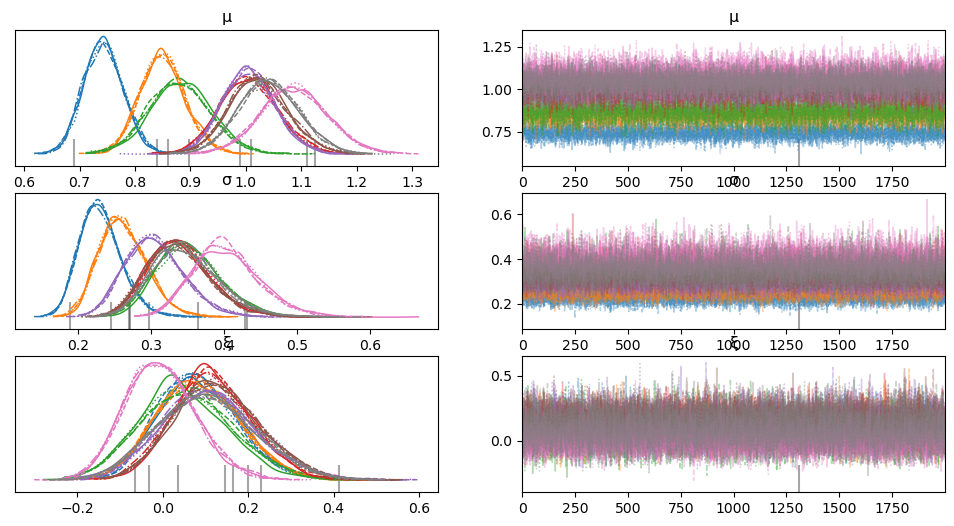

In [11]:
az.plot_trace(unpooled_trace, var_names=["μ", "σ", "ξ"]);

In [12]:
az.summary(unpooled_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[BOS],0.743,0.036,0.677,0.815,0.000,0.000,6456.0,5197.0,1.0
μ[PVD],0.850,0.041,0.773,0.932,0.000,0.000,8071.0,6055.0,1.0
μ[BDL],0.880,0.055,0.772,0.991,0.001,0.000,6458.0,5516.0,1.0
μ[JFK],1.006,0.052,0.908,1.113,0.001,0.000,6363.0,5621.0,1.0
μ[LGA],1.005,0.048,0.911,1.097,0.001,0.000,6817.0,5887.0,1.0
μ[EWR],1.023,0.053,0.923,1.130,0.001,0.000,6567.0,6012.0,1.0
μ[PHL],1.087,0.060,0.970,1.206,0.001,0.000,7791.0,5958.0,1.0
μ[ILG],1.041,0.054,0.941,1.153,0.001,0.000,6902.0,6312.0,1.0
σ[BOS],0.231,0.029,0.179,0.290,0.000,0.000,6301.0,5428.0,1.0
σ[PVD],0.262,0.033,0.199,0.325,0.000,0.000,7307.0,5913.0,1.0


In [13]:
# def plot_station_rl(idata, station, hdi=0.95):
#     x_data = az.extract(idata.posterior,var_names=['rl']).rp
#     y_data = az.extract(idata.posterior,var_names=['rl']).sel(station=station)
#     y_mean = y_data.mean(dim='sample')
#     y_L = y_data.quantile(0.025, dim='sample')
#     y_U = y_data.quantile(0.975, dim='sample')

#     plt.plot(x_data, y_mean)
#     plt.fill_between(x_data, y_L, y_U,alpha=0.25)
#     plt.xscale("log")
#     plt.show()


In [14]:
# def station_rl(idata, station, hdi=0.95):
#     x_data = az.extract(idata.posterior,var_names=['rl']).rp
#     y_data = az.extract(idata.posterior,var_names=['rl']).sel(station=station)
#     y_mean = y_data.mean(dim='sample')
#     y_L = y_data.quantile(0.025, dim='sample')
#     y_U = y_data.quantile(0.975, dim='sample')

#     return pd.DataFrame({
#             'mean': y_mean,
#             'hdi_2.5%' : y_L,
#             'hdi_97.5%' : y_U,
#         }, index = x_data)

In [15]:
# def rl_100y(idata, hdi=0.95):
#     x_data = az.extract(idata.posterior,var_names=['rl']).station
#     y_data = az.extract(idata.posterior,var_names=['rl']).sel(rp=100.0)
#     y_mean = y_data.mean(dim='sample')
#     y_L = y_data.quantile(0.025, dim='sample')
#     y_U = y_data.quantile(0.975, dim='sample')

#     return pd.DataFrame({
#             'mean': y_mean,
#             'hdi_2.5%' : y_L,
#             'hdi_97.5%' : y_U,
#         }, index = x_data)

In [29]:
df_X_y_

,date,station,PRCP,X,Y
0,1971,BOS,0.54,-5962.884146,4710.280474
1,1971,PVD,1.09,-5998.385317,4639.263610
2,1971,BDL,0.83,-6103.351287,4663.303953
3,1971,JFK,0.88,-6194.018372,4518.807258
4,1971,LGA,0.92,-6203.932198,4534.467951
...,...,...,...,...,...
411,2022,JFK,0.79,-6194.018372,4518.807258
412,2022,LGA,1.07,-6203.932198,4534.467951
413,2022,EWR,0.71,-6228.203689,4523.712066
414,2022,PHL,1.22,-6316.988945,4433.714228


In [16]:
coords = {
    "cov_params": ["mu","sigma"],
    "location" : ["x","y"],
    "lonlat" : ["longitude", "latitude"],
    "station" : stations,
    "obs" : df_X_y_.index,
    "rp" : return_periods,
}

with pm.Model(coords=coords) as gp_model:
    pt_station_idx = pm.ConstantData("station_idx", station_idx, dims="obs")
    pt_X_lonlat = pm.ConstantData("station_loc", X_lonlat, dims=("station","lonlat"))
    #hyper parameters
    ℓ = pm.InverseGamma("ℓ", mu = 100.0, sigma = 50.0, dims="cov_params")
    η = pm.Gamma("η", mu=0.15, sigma=0.15, dims = "cov_params")
    #gaussian process prior for mu
    cov_μ = η[0]**2 * Matern32Chordal(2, ℓ[0])
    gp_μ = pm.gp.Latent(cov_func=cov_μ)
    μ_group = pm.Normal("μ_group", mu=1.0, sigma=1.0)
    μ = pm.Deterministic("μ", μ_group + gp_μ.prior("μ_gp", X=pt_X_lonlat, dims="station"), dims="station")
    #gaussian process prior for sigma
    cov_σ_log = η[1]**2 * Matern32Chordal(2, ℓ[1])
    gp_σ_log = pm.gp.Latent(cov_func=cov_σ_log)
    σ_log = gp_σ_log.prior("σ_log", X=pt_X_lonlat, dims="station")
    σ_log_group = pm.Normal("σ_log_group", mu=-1.0, sigma=2.0)
    σ = pm.Deterministic("σ", pm.math.exp(σ_log_group + σ_log))
    # prior for shape
    ξ = pm.TruncatedNormal('ξ', mu=0.0, sigma=0.2, lower=-0.99, upper=0.99)
    # likelihood for all observations
    gev = pmx.GenExtreme("gev", mu=μ[pt_station_idx], sigma=σ[pt_station_idx], xi=ξ, observed=y_, dims="obs")
    # return levels
    rl = pm.Deterministic("rl", μ[:,None] - σ[:,None] / ξ * (1 - (-np.log(1 - p[None:,])) ** (-ξ)), dims=('station','rp'))
    # mcmc sampling
    gp_trace = pm.sample(1000, tune = 1000, target_accept = 0.98 )

# pm.model_to_graphviz(gp_model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ℓ, η, μ_group, μ_gp_rotated_, σ_log_rotated_, σ_log_group, ξ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 485 seconds.


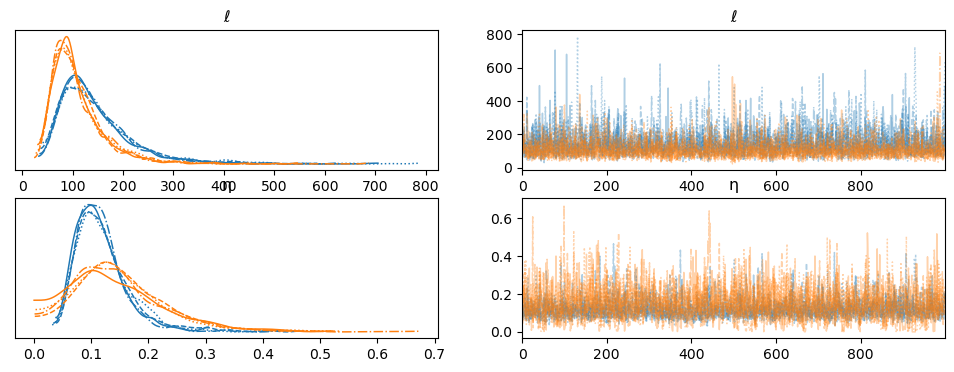

In [18]:
az.plot_trace(gp_trace, var_names=["ℓ", "η"]);

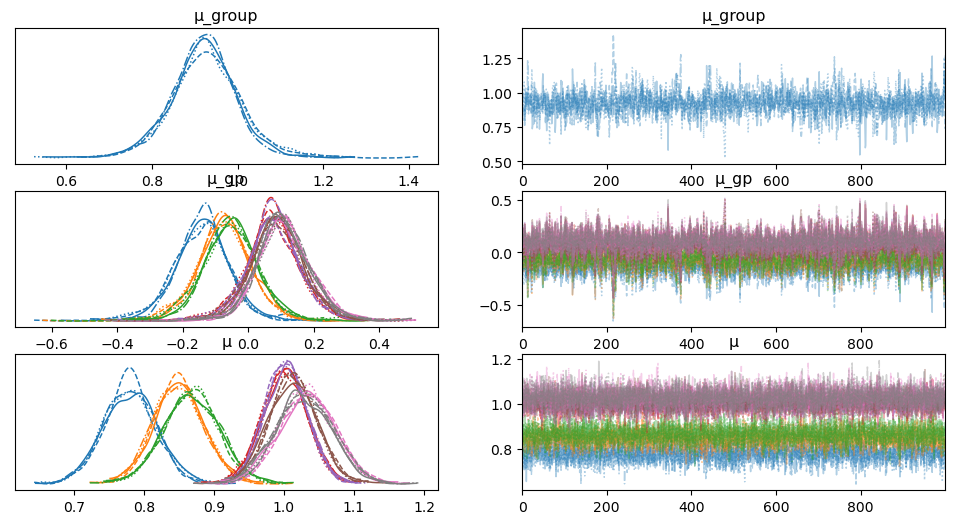

In [19]:
az.plot_trace(gp_trace, var_names=["μ_group","μ_gp","μ"]);

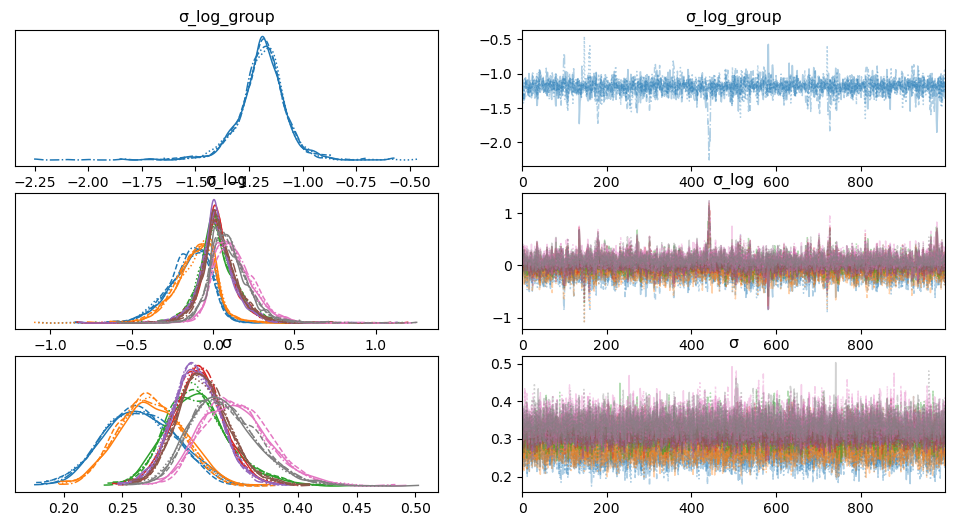

In [20]:
az.plot_trace(gp_trace, var_names=["σ_log_group","σ_log","σ"]);

In [21]:
az.summary(gp_trace,var_names=["ℓ", "η"],hdi_prob= 0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ℓ[mu],146.552,76.880,40.697,292.103,1.524,1.101,2840.0,2856.0,1.00
ℓ[sigma],109.003,52.953,36.501,214.783,0.937,0.723,4294.0,2791.0,1.00
η[mu],0.119,0.048,0.048,0.211,0.001,0.001,1983.0,2276.0,1.00
η[sigma],0.146,0.084,0.000,0.301,0.002,0.002,1127.0,1063.0,1.01


In [22]:
az.summary(gp_trace,var_names=["μ", "σ", "ξ"],hdi_prob= 0.95).sort_values('r_hat')

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[BOS],0.780,0.037,0.704,0.852,0.001,0.000,3134.0,2651.0,1.0
σ[6],0.347,0.029,0.293,0.403,0.001,0.000,2629.0,3073.0,1.0
σ[5],0.319,0.023,0.277,0.367,0.000,0.000,5379.0,3925.0,1.0
σ[4],0.314,0.021,0.271,0.356,0.000,0.000,5564.0,3999.0,1.0
σ[3],0.315,0.022,0.272,0.358,0.000,0.000,5571.0,4145.0,1.0
σ[2],0.315,0.028,0.264,0.375,0.000,0.000,4893.0,3762.0,1.0
σ[1],0.274,0.027,0.223,0.327,0.001,0.000,2010.0,2215.0,1.0
σ[7],0.337,0.029,0.286,0.397,0.000,0.000,4655.0,3872.0,1.0
σ[0],0.265,0.031,0.209,0.326,0.001,0.001,1781.0,1806.0,1.0
μ[PHL],1.033,0.040,0.957,1.111,0.001,0.000,4209.0,3731.0,1.0


In [23]:
X_sample = X_lonlat
jitter = 1e-6

# gp_model.add_coords({"rp": return_periods})

with gp_model:
     p = pm.ConstantData("p", 1/return_periods, dims="rp")

     μ_pred = pm.Deterministic("μ_pred", μ_group + gp_μ.conditional("μ_gp_pred", Xnew=X_sample, jitter=jitter))
     σ_pred = pm.Deterministic("σ_pred", pm.math.exp(σ_log_group+gp_σ_log.conditional("σ_log_pred", Xnew=X_sample, jitter=jitter)))

     rl_100_pred = pm.Deterministic("rl_100_pred", μ_pred - σ_pred / ξ * (1 - (-np.log(1 - 1/100)) ** (-ξ)), dims='station')
     # rl = pm.Deterministic("rl4", μ_pred[:,None] - σ_pred[:,None] / ξ * (1 - (-np.log(1 - p[None:,])) ** (-ξ)), dims=('station','rp'))

     posterior_pred = pm.sample_posterior_predictive(gp_trace,var_names=['rl_100_pred'])

Sampling: [μ_gp_pred, σ_log_pred]


In [ ]:
# pm.model_to_graphviz(gp_model)

In [ ]:
# az.summary(posterior_pred, var_names="rl4")
# az.summary(posterior_pred.posterior_predictive, var_names="rl4",coords={'station':'BOS'})

In [ ]:
# plt.plot(az.summary(gp_trace,var_names=["rl_100"],hdi_prob= 0.95)['mean'])
# plt.plot(az.summary(unpooled_trace,var_names=["rl_100"],hdi_prob= 0.95)['mean'])

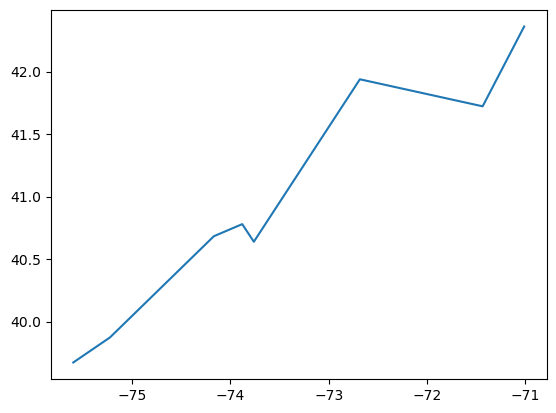

In [ ]:
plt.plot(X_lonlat[:,0],X_lonlat[:,1])

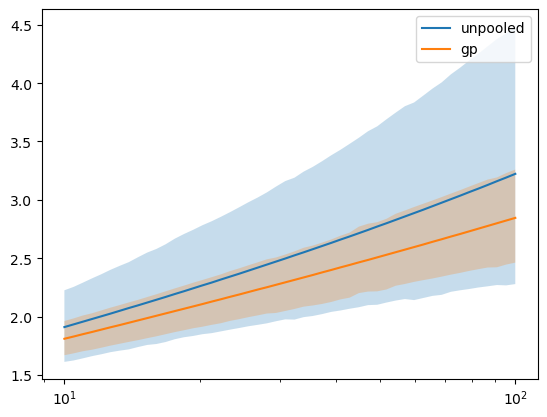

In [25]:
station = 'EWR'

x = unpooled_trace.posterior.rp
y_data = az.summary(unpooled_trace, var_names="rl",coords={'station':station},hdi_prob=0.95)
y_mean = y_data['mean']
y_L = y_data['hdi_2.5%']
y_U = y_data['hdi_97.5%']

z_data = az.summary(gp_trace, var_names="rl",coords={'station':station},hdi_prob=0.95)
z_mean = z_data['mean']
z_L = z_data['hdi_2.5%']
z_U = z_data['hdi_97.5%']

plt.plot(x,y_mean,label='unpooled')
plt.fill_between(x.to_numpy(),y_L.to_numpy(),y_U.to_numpy(),alpha=0.25)

plt.plot(x,z_mean,label='gp')
plt.fill_between(x.to_numpy(),z_L.to_numpy(),z_U.to_numpy(),alpha=0.25)
plt.legend()

plt.xscale("log")

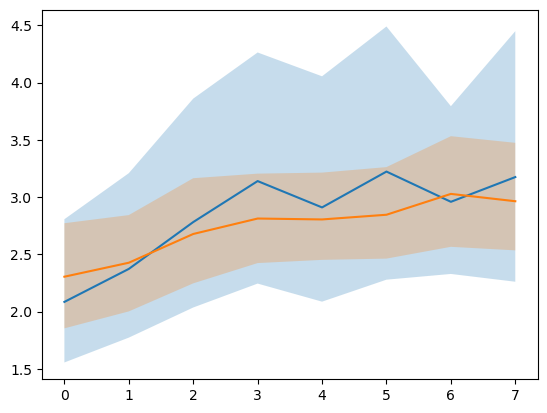

In [26]:

y_data = az.summary(unpooled_trace,var_names=['rl'],hdi_prob=0.95,coords={'rp':100})
y_mean = y_data['mean']
y_L = y_data['hdi_2.5%']
y_U = y_data['hdi_97.5%']

z_data = az.summary(posterior_pred.posterior_predictive,var_names=['rl_100_pred'],hdi_prob=0.95)
z_mean = z_data['mean']
z_L = z_data['hdi_2.5%']
z_U = z_data['hdi_97.5%']

x = range(len(z_mean))

plt.plot(x, y_mean)
plt.fill_between(x, y_L.to_numpy(), y_U.to_numpy(),alpha=0.25)

plt.plot(x, z_mean)
plt.fill_between(x, z_L.to_numpy(), z_U.to_numpy(),alpha=0.25)

In [27]:
az.summary(unpooled_trace,var_names=['rl'],hdi_prob=0.95,coords={'rp':100})

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
rl[BOS],2.085,0.374,1.556,2.807,0.006,0.005,7718.0,4769.0,1.0
rl[PVD],2.373,0.420,1.773,3.209,0.005,0.004,8572.0,4928.0,1.0
rl[BDL],2.782,0.531,2.036,3.860,0.007,0.005,9084.0,5149.0,1.0
rl[JFK],3.140,0.584,2.245,4.263,0.008,0.006,8066.0,5302.0,1.0
rl[LGA],2.910,0.583,2.087,4.055,0.008,0.007,9323.0,4602.0,1.0
rl[EWR],3.223,0.646,2.279,4.490,0.008,0.006,9452.0,4722.0,1.0
rl[PHL],2.959,0.417,2.329,3.794,0.005,0.004,8422.0,5293.0,1.0
rl[ILG],3.175,0.650,2.261,4.449,0.008,0.006,8945.0,4730.0,1.0
